In [5]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Downsample 90% normal traffic randomly
Split train and test subgraph stratigically
Training in chronological window subgraph

IP as node
Encode Ports in 3 Categories
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [6]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "random_window_categorical_port"

SOURCE_FILE_ID_COL_NAME = UNSW_NB15_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

CATEGORICAL_COLS = UNSW_NB15_Config.CATEGORICAL_COLS

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

attack_cat
Normal            221876
Generic           215481
Exploits           44525
Fuzzers            24246
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoors           2329
Shellcode           1511
Worms                174
Name: count, dtype: int64
label
1    321283
0    221876
Name: count, dtype: int64


In [7]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [8]:
data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# Port category encoding: 
def port_category(port_str):
    try:
        port_int = int(port_str)
        if 1 <= port_int <= 1023:
            return [1, 0, 0]  # Well Known
        elif 1024 <= port_int <= 49151:
            return [0, 1, 0]  # Registered
        elif 49152 <= port_int <= 65535:
            return [0, 0, 1]  # Dynamic/Private
        else:
            return [0, 0, 0]  # Out of range, encode as all zeros
    except:
        return [0, 0, 0]  # Non-integer or missing, encode as all zeros

# Create new columns for binary encoding
src_port_category = data[SOURCE_PORT_COL_NAME].apply(port_category)
dst_port_category = data[DESTINATION_PORT_COL_NAME].apply(port_category)

src_port_category_df = pd.DataFrame(src_port_category.tolist(), columns=[f"{SOURCE_PORT_COL_NAME}_category_{i}" for i in range(3)])
dst_port_category_df = pd.DataFrame(dst_port_category.tolist(), columns=[f"{DESTINATION_PORT_COL_NAME}_category_{i}" for i in range(3)])

# Concatenate the binary columns to the original dataframe
data = pd.concat([data, src_port_category_df, dst_port_category_df], axis=1)

data.drop(columns=[SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME], inplace=True)

converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]))]

In [9]:
print(data.head)

<bound method NDFrame.head of                  srcip             dstip        dur  sbytes  dbytes  sttl  \
0         10.40.85.1_0       224.0.0.5_0  50.004341     384       0     1   
1         59.166.0.6_0   149.171.126.4_0   0.001134     132     164    31   
2       175.45.176.0_0  149.171.126.16_0   2.390390    1362     268   254   
3         59.166.0.3_0   149.171.126.8_0  34.077175   37358    3380    31   
4        10.40.170.2_0     10.40.170.2_0   0.000000      46       0     0   
...                ...               ...        ...     ...     ...   ...   
543154  175.45.176.1_3  149.171.126.11_3   0.291164     732     468   254   
543155  175.45.176.3_3  149.171.126.16_3   0.011751      76     132   254   
543156    59.166.0.2_3   149.171.126.4_3   0.002410     146     178    31   
543157  175.45.176.1_3  149.171.126.11_3   0.176514   10778     268   254   
543158    59.166.0.2_3   149.171.126.2_3   0.049598    2646   25564    31   

        dttl  sloss  dloss          Sload  ..

In [10]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                  srcip             dstip        dur  sbytes  dbytes  sttl  \
0         10.40.85.1_0       224.0.0.5_0  50.004341     384       0     1   
1         59.166.0.6_0   149.171.126.4_0   0.001134     132     164    31   
2       175.45.176.0_0  149.171.126.16_0   2.390390    1362     268   254   
3         59.166.0.3_0   149.171.126.8_0  34.077175   37358    3380    31   
4        10.40.170.2_0     10.40.170.2_0   0.000000      46       0     0   
...                ...               ...        ...     ...     ...   ...   
543154  175.45.176.1_3  149.171.126.11_3   0.291164     732     468   254   
543155  175.45.176.3_3  149.171.126.16_3   0.011751      76     132   254   
543156    59.166.0.2_3   149.171.126.4_3   0.002410     146     178    31   
543157  175.45.176.1_3  149.171.126.11_3   0.176514   10778     268   254   
543158    59.166.0.2_3   149.171.126.2_3   0.049598    2646   25564    31   

        dttl  sloss  dloss          Sload  ..

In [11]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                 dur        sbytes        dbytes           sttl  \
count  543159.000000  5.431590e+05  5.431590e+05  543159.000000   
mean        0.703562  5.129376e+03  1.912066e+04     157.223966   
std        12.635598  1.202304e+05  1.382834e+05     108.429349   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000007  1.140000e+02  0.000000e+00      31.000000   
50%         0.000010  2.000000e+02  0.000000e+00     254.000000   
75%         0.070875  1.580000e+03  1.936000e+03     254.000000   
max      8760.776367  1.435577e+07  1.465753e+07     255.000000   

                dttl          sloss          dloss         Sload  \
count  543159.000000  543159.000000  543159.000000  5.431590e+05   
mean       38.847354       3.789714       8.637535  6.901181e+07   
std        77.059190      45.614073      49.869719  1.425974e+08   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.000000       0.000000  3.76

In [12]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [13]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [14]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [15]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH', 'sport_category_0', 'sport_category_1', 'sport_category_2', 'dsport_category_0', 'dsport_category_1', 'dsport_category_2']
Number of Features: 58


In [16]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [17]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols=[SOURCE_FILE_ID_COL_NAME] + TIME_COLS + [ATTACK_CLASS_COL_NAME], 
    label_col=label_col,
    build_graph_func=create_graph,
    # downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    # X, y = downsampler.downsample(label_counts_list, X, y)
        
    return StratifiedGraphDataset(X, y)

In [18]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
       'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'attack_cat', 'source_file_id', 'state_ACC', 'state_CLO', 'state_CON',
       'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS',
       'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD',
       'state_URH', 'sport_category_0', 'sport_category_1', 'sport_category_2',
       'dsport_category_0', 'dsport_category_1', 'dsport_category_2', 'h'],
      dtype='object')
Ordering Columns:  ['source_file_id', 'Stime', 'Lti

Generating graphs: 100%|██████████| 2716/2716 [00:22<00:00, 120.37it/s]


In [19]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: attack_cat
6    221876
5    215481
3     44525
4     24246
2     16353
7     13987
0      2677
1      2329
8      1511
9       174
Name: count, dtype: int64
Number of graphs after downsampling: 2716
Class Counts and Weights:
6   Normal         : Count = 221876    , Weight = 0.2448    
7   Reconnaissance : Count = 13987     , Weight = 3.8833    
2   DoS            : Count = 16353     , Weight = 3.3215    
5   Generic        : Count = 215481    , Weight = 0.2521    
3   Exploits       : Count = 44525     , Weight = 1.2199    
8   Shellcode      : Count = 1511      , Weight = 35.9470   
4   Fuzzers        : Count = 24246     , Weight = 2.2402    
9   Worms          : Count = 174       , Weight = 312.1603  
1   Backdoors      : Count = 2329      , Weight = 23.3216   
0   Analysis       : Count = 2677      , Weight = 20.2898   
Number of training graphs: 2308
Class Counts and Weights:
6   Normal         : Count = 187802    , Weight = 0.2458    
7   Reconnaissance : Count

In [20]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [21]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
th.cuda.empty_cache()

In [23]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [24]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [25]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [26]:
import pickle

def save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [27]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 1000

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Number of train graphs:  1961
Class weights: tensor([1.9630e+01, 2.2776e+01, 3.2804e+00, 1.2167e+00, 2.1546e+00, 2.5481e-01,
        2.4399e-01, 3.8455e+00, 3.5622e+01, 3.1127e+02], device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.7289034387417161
Epoch 0, Train Loss: 2.2943, Validation Loss: 8.2003, Validation F1: 0.7289


Epoch 3 Saved best model. Best F1: 0.7578573908593319


Epoch 5 Saved best model. Best F1: 0.7894494594744927


Epoch 6 Saved best model. Best F1: 0.8403696797719549


Epoch 9 Saved best model. Best F1: 0.8510699383239811


Epoch 10, Train Loss: 1.1441, Validation Loss: 1.2624, Validation F1: 0.7973


Epoch 14 Saved best model. Best F1: 0.8635945090059465


Epoch 15 Saved best model. Best F1: 0.8683440375731348


Epoch 20, Train Loss: 1.0039, Validation Loss: 1.0154, Validation F1: 0.8649


Epoch 22 Saved best model. Best F1: 0.871399691569083


Epoch 27 Saved best model. Best F1: 0.8725498443179004


Epoch 28 Saved best model. Best F1: 0.873122335440176


Epoch 30, Train Loss: 0.9084, Validation Loss: 0.9276, Validation F1: 0.8710


Epoch 31 Saved best model. Best F1: 0.8741385466817299


Epoch 33 Saved best model. Best F1: 0.8761302283093485


Epoch 35 Saved best model. Best F1: 0.8771579796189279


Epoch 38 Saved best model. Best F1: 0.8810092127540179


Epoch 40, Train Loss: 0.8580, Validation Loss: 0.8842, Validation F1: 0.8713


Epoch 50, Train Loss: 0.8279, Validation Loss: 0.8574, Validation F1: 0.8761


Epoch 58 Saved best model. Best F1: 0.8817509260432307


Epoch 60, Train Loss: 0.8091, Validation Loss: 0.8451, Validation F1: 0.8767


Epoch 64 Saved best model. Best F1: 0.882541704254246


Epoch 70, Train Loss: 0.7896, Validation Loss: 0.8364, Validation F1: 0.8815


Epoch 75 Saved best model. Best F1: 0.8837639110950644


Epoch 80, Train Loss: 0.7822, Validation Loss: 0.8429, Validation F1: 0.8763


Epoch 90, Train Loss: 0.7660, Validation Loss: 0.8337, Validation F1: 0.8807


Epoch 100, Train Loss: 0.7585, Validation Loss: 0.8321, Validation F1: 0.8801


Epoch 102 Saved best model. Best F1: 0.8845404060422865


Epoch 106 Saved best model. Best F1: 0.8852271976472853


Epoch 110, Train Loss: 0.7546, Validation Loss: 0.8260, Validation F1: 0.8680


Epoch 120, Train Loss: 0.7420, Validation Loss: 0.8125, Validation F1: 0.8768


Epoch 130, Train Loss: 0.7349, Validation Loss: 0.8277, Validation F1: 0.8730


Epoch 140, Train Loss: 0.7432, Validation Loss: 0.8151, Validation F1: 0.8762


Epoch 150, Train Loss: 0.7353, Validation Loss: 0.8176, Validation F1: 0.8824


Epoch 160, Train Loss: 0.7169, Validation Loss: 0.8161, Validation F1: 0.8721


Epoch 170, Train Loss: 0.7095, Validation Loss: 0.8162, Validation F1: 0.8705


Epoch 180, Train Loss: 0.7114, Validation Loss: 0.8048, Validation F1: 0.8800


Epoch 190, Train Loss: 0.7011, Validation Loss: 0.8107, Validation F1: 0.8761


Epoch 196 Saved best model. Best F1: 0.8868079984936273


Epoch 200, Train Loss: 0.6967, Validation Loss: 0.8231, Validation F1: 0.8710


Epoch 210 Saved best model. Best F1: 0.8874339911628709
Epoch 210, Train Loss: 0.7198, Validation Loss: 0.8489, Validation F1: 0.8874


Epoch 220, Train Loss: 0.6975, Validation Loss: 0.8177, Validation F1: 0.8744


Epoch 230, Train Loss: 0.6867, Validation Loss: 0.8173, Validation F1: 0.8755


Epoch 240, Train Loss: 0.6806, Validation Loss: 0.8121, Validation F1: 0.8818


Epoch 250, Train Loss: 0.6748, Validation Loss: 0.8089, Validation F1: 0.8738


Epoch 260, Train Loss: 0.6736, Validation Loss: 0.8290, Validation F1: 0.8824


Epoch 270, Train Loss: 0.6758, Validation Loss: 0.8168, Validation F1: 0.8812


Epoch 280, Train Loss: 0.6971, Validation Loss: 0.8252, Validation F1: 0.8736


Epoch 290, Train Loss: 0.6671, Validation Loss: 0.8104, Validation F1: 0.8840


Epoch 300, Train Loss: 0.6597, Validation Loss: 0.8206, Validation F1: 0.8825


Epoch 310, Train Loss: 0.6550, Validation Loss: 0.8162, Validation F1: 0.8826


Epoch 320, Train Loss: 0.6497, Validation Loss: 0.8278, Validation F1: 0.8817


Epoch 330, Train Loss: 0.6456, Validation Loss: 0.8194, Validation F1: 0.8789


Epoch 340, Train Loss: 0.6419, Validation Loss: 0.8214, Validation F1: 0.8806


Epoch 350, Train Loss: 0.6414, Validation Loss: 0.8257, Validation F1: 0.8787


Epoch 360, Train Loss: 0.6395, Validation Loss: 0.8145, Validation F1: 0.8835


Epoch 370, Train Loss: 0.6334, Validation Loss: 0.8407, Validation F1: 0.8850


Epoch 380, Train Loss: 0.6304, Validation Loss: 0.8311, Validation F1: 0.8846


Epoch 390, Train Loss: 0.6261, Validation Loss: 0.8297, Validation F1: 0.8834


Epoch 400, Train Loss: 0.6231, Validation Loss: 0.8308, Validation F1: 0.8835


Epoch 410, Train Loss: 0.6206, Validation Loss: 0.8394, Validation F1: 0.8818


Epoch 420, Train Loss: 0.6172, Validation Loss: 0.8289, Validation F1: 0.8823


Epoch 430, Train Loss: 0.6139, Validation Loss: 0.8342, Validation F1: 0.8799


Epoch 440, Train Loss: 0.6118, Validation Loss: 0.8384, Validation F1: 0.8832


Epoch 450, Train Loss: 0.6104, Validation Loss: 0.8358, Validation F1: 0.8809


Epoch 460, Train Loss: 0.6073, Validation Loss: 0.8431, Validation F1: 0.8824


Epoch 470, Train Loss: 0.6123, Validation Loss: 0.8392, Validation F1: 0.8745


Epoch 480, Train Loss: 0.6152, Validation Loss: 0.8694, Validation F1: 0.8759


Epoch 490, Train Loss: 0.6081, Validation Loss: 0.8513, Validation F1: 0.8759


Epoch 500, Train Loss: 0.6036, Validation Loss: 0.8383, Validation F1: 0.8787


Epoch 510, Train Loss: 0.5992, Validation Loss: 0.8713, Validation F1: 0.8790


Epoch 520, Train Loss: 0.5987, Validation Loss: 0.8632, Validation F1: 0.8786


Epoch 530, Train Loss: 0.5957, Validation Loss: 0.8619, Validation F1: 0.8800


Epoch 540, Train Loss: 0.5938, Validation Loss: 0.8625, Validation F1: 0.8832


Epoch 550, Train Loss: 0.5917, Validation Loss: 0.8664, Validation F1: 0.8822


Epoch 560, Train Loss: 0.5917, Validation Loss: 0.8512, Validation F1: 0.8806


Epoch 570, Train Loss: 0.5906, Validation Loss: 0.8640, Validation F1: 0.8809


Epoch 580, Train Loss: 0.5886, Validation Loss: 0.8634, Validation F1: 0.8834


Epoch 590, Train Loss: 0.5887, Validation Loss: 0.8730, Validation F1: 0.8806


Epoch 600, Train Loss: 0.5864, Validation Loss: 0.8794, Validation F1: 0.8815


Epoch 610, Train Loss: 0.5851, Validation Loss: 0.8841, Validation F1: 0.8805


Epoch 620, Train Loss: 0.5846, Validation Loss: 0.8801, Validation F1: 0.8810


Epoch 630, Train Loss: 0.5836, Validation Loss: 0.8807, Validation F1: 0.8819


Epoch 640, Train Loss: 0.5816, Validation Loss: 0.8866, Validation F1: 0.8810


Epoch 650, Train Loss: 0.5817, Validation Loss: 0.8939, Validation F1: 0.8821


Epoch 660, Train Loss: 0.5808, Validation Loss: 0.8858, Validation F1: 0.8830


Epoch 670, Train Loss: 0.5803, Validation Loss: 0.8839, Validation F1: 0.8807


Epoch 680, Train Loss: 0.5806, Validation Loss: 0.8863, Validation F1: 0.8818


Epoch 690, Train Loss: 0.5796, Validation Loss: 0.8899, Validation F1: 0.8821


Epoch 700, Train Loss: 0.5786, Validation Loss: 0.9054, Validation F1: 0.8824


Epoch 710, Train Loss: 0.5781, Validation Loss: 0.8867, Validation F1: 0.8817


Epoch 720, Train Loss: 0.5768, Validation Loss: 0.8989, Validation F1: 0.8803


Epoch 730, Train Loss: 0.5772, Validation Loss: 0.8904, Validation F1: 0.8814


Epoch 740, Train Loss: 0.5764, Validation Loss: 0.8873, Validation F1: 0.8813


Epoch 750, Train Loss: 0.5755, Validation Loss: 0.9049, Validation F1: 0.8822


Epoch 760, Train Loss: 0.5759, Validation Loss: 0.9068, Validation F1: 0.8805


Epoch 770, Train Loss: 0.5754, Validation Loss: 0.9004, Validation F1: 0.8819


Epoch 780, Train Loss: 0.5754, Validation Loss: 0.8920, Validation F1: 0.8826


Epoch 790, Train Loss: 0.5747, Validation Loss: 0.9101, Validation F1: 0.8825


Epoch 800, Train Loss: 0.5737, Validation Loss: 0.9230, Validation F1: 0.8823


Epoch 810, Train Loss: 0.5747, Validation Loss: 0.9078, Validation F1: 0.8814


Epoch 820, Train Loss: 0.5729, Validation Loss: 0.9007, Validation F1: 0.8827


Epoch 830, Train Loss: 0.5745, Validation Loss: 0.8984, Validation F1: 0.8820


Epoch 840, Train Loss: 0.5733, Validation Loss: 0.9057, Validation F1: 0.8834


Epoch 850, Train Loss: 0.5736, Validation Loss: 0.9105, Validation F1: 0.8816


Epoch 860, Train Loss: 0.5737, Validation Loss: 0.9017, Validation F1: 0.8801


Epoch 870, Train Loss: 0.5726, Validation Loss: 0.9295, Validation F1: 0.8816


Epoch 880, Train Loss: 0.5728, Validation Loss: 0.9152, Validation F1: 0.8804


Epoch 890, Train Loss: 0.5725, Validation Loss: 0.9148, Validation F1: 0.8819


Epoch 900, Train Loss: 0.5725, Validation Loss: 0.8980, Validation F1: 0.8820


Epoch 910, Train Loss: 0.5721, Validation Loss: 0.8989, Validation F1: 0.8814


Epoch 920, Train Loss: 0.5718, Validation Loss: 0.9171, Validation F1: 0.8826


Epoch 930, Train Loss: 0.5722, Validation Loss: 0.9141, Validation F1: 0.8827


Epoch 940, Train Loss: 0.5717, Validation Loss: 0.9002, Validation F1: 0.8817


Epoch 950, Train Loss: 0.5724, Validation Loss: 0.9191, Validation F1: 0.8821


Epoch 960, Train Loss: 0.5722, Validation Loss: 0.9147, Validation F1: 0.8827


Epoch 970, Train Loss: 0.5707, Validation Loss: 0.9089, Validation F1: 0.8817


Epoch 980, Train Loss: 0.5728, Validation Loss: 0.9120, Validation F1: 0.8824


Epoch 990, Train Loss: 0.5720, Validation Loss: 0.9069, Validation F1: 0.8827


Model training completed and saved.


In [28]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

1000


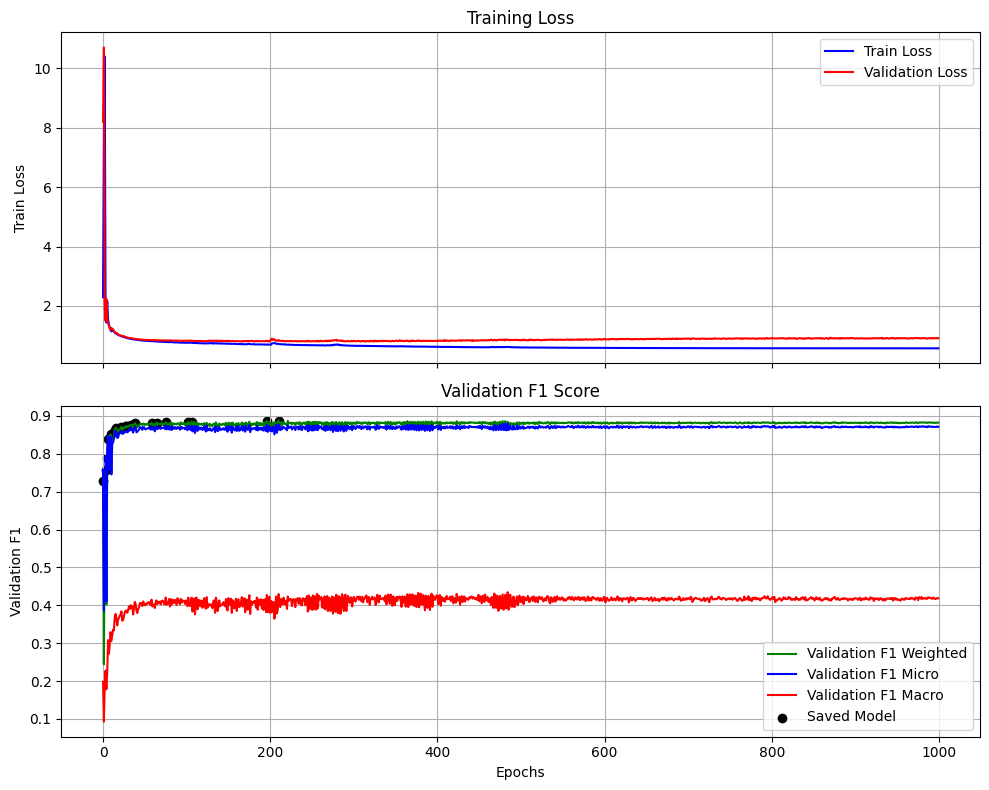

In [29]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [30]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  408
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/random_window_categorical_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.8753
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   91    28   191    15     9     0     0     2     1     0]
 [   30    37   204     7     6     2     0    18    19     3]
 [  121   154  1421   233    66     6     0   128   153    14]
 [  244   237  1927  2103   473    80     0   750   918   109]
 [   59    73   242   114  2359    27     0   184   149    19]
 [   24   158   233   205   140 31010     0   113   176    18]
 [   33     5    12    67   320    15 33452    57   103    10]
 [   25    39   302   316   218    30     2   797   391    51]
 [    1     5     9    21    18     6     0    13   153     0]
 [    0     0     1     6     3     0     0     8     6     2]]
                precision    recall  f1-score   support

      Analysis     0.1449    0.2700    0.1886       337
     Backdoors     0.0503    0.1135    0.0697       326
           DoS     0.3129    0.6189    0.4156      2296
   

In [31]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        # raise ValueError("No attacker nodes found.")
        return graph

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [32]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/random_window_categorical_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7849
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  87   83  373  525 2576  460  515  460 1296  425    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   64    40   193    16     6     0    15     2     1     0]
 [   23    44   190    20     5     4     9    16    12     3]
 [   23   210  1399   231    48    34   136   128    69    18]
 

In [33]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/random_window_categorical_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7858
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  51   30  239 1089  293   90 3971  310  686   41    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  103    46   104    38     1     1    11    29     0     4]
 [   47    55   107    27     2    10    18    56     3     1]
 [  250   228   799   328    18    63   115   442    38    15]
 

In [34]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [35]:
# Inject Random Nodes in the graph
injected_graph_dataset = [inject_random_nodes(g.cpu(), 0.1, num_injected_nodes=1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/random_window_categorical_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7812
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  66   82  296  491  958  546 4425  237  899  160    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   61    36   194    22     7     0     9     5     2     1]
 [   25    42   196    16     4     4     4    18    14     3]
 [   28   208  1419   220    70    22    44   162   103    20]
 